# Import Resources

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import json
import tensorflow_hub as hub

from tensorflow.keras import regularizers

# Load the Dataset

In [2]:
datasets, datainfo = tfds.load(
    'oxford_flowers102', 
    with_info=True, 
    as_supervised=True
)

In [3]:
train_set = datasets['test']
test_set = datasets['train']
validation_set = datasets['validation']

# Explore the Dataset

In [4]:
# Get the number of examples in each set from the dataset info

num_examples_train = datainfo.splits['test'].num_examples
num_examples_test = datainfo.splits['train'].num_examples
num_examples_validation = datainfo.splits['validation'].num_examples

print("The number of examples in train dataset: {}".format(num_examples_train))
print("The number of examples in test dataset: {}".format(num_examples_test))
print("The number of examples in validation dataset: {}".format(num_examples_validation))

The number of examples in train dataset: 6149
The number of examples in test dataset: 1020
The number of examples in validation dataset: 1020


In [5]:
# Get the number of classes in the dataset from the dataset info.

num_classes = datainfo.features['label'].num_classes

print("The number of classes in the dataset: {}".format(num_classes))

The number of classes in the dataset: 102


In [6]:
# Print the shape and corresponding label of 3 images in the training set.

for image, label in train_set.take(3):
    print('The images in the training set have:')
    print('\u2022 shape:', image.shape)
  
    print('\nThe label of the image:')
    print('\u2022 ', label)
    
    print("***************************************")

The images in the training set have:
• shape: (542, 500, 3)

The label of the image:
•  tf.Tensor(40, shape=(), dtype=int64)
***************************************
The images in the training set have:
• shape: (748, 500, 3)

The label of the image:
•  tf.Tensor(76, shape=(), dtype=int64)
***************************************
The images in the training set have:
• shape: (500, 600, 3)

The label of the image:
•  tf.Tensor(42, shape=(), dtype=int64)
***************************************


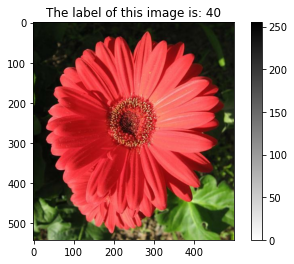

In [7]:
#  Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label.

for image, label in train_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.title('The label of this image is: {}'.format(label))
plt.show()

### Label Mapping

In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

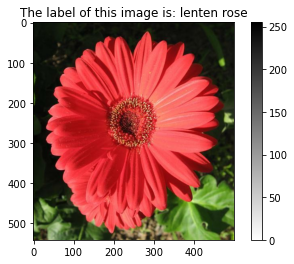

In [9]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name.

for image, label in train_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.title('The label of this image is: {}'.format(class_names[str(label)]))
plt.show()

### Create Pipeline

In [10]:
IMG_WIDTH=224
IMG_HEIGHT=224
batch_size = 64

In [11]:
def augment(image, label):
    
    image = tf.image.flip_left_right(image)
    
    
    
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    
    return image,label

In [12]:
def process_image(image, label):
    
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    
    return image, label

In [13]:
train_set = train_set.map(process_image)
test_set = test_set.map(process_image)
validation_set = validation_set.map(process_image)

In [14]:
train_batches = train_set.shuffle(num_examples_train).batch(batch_size).prefetch(1)
test_batches = test_set.shuffle(num_examples_test).batch(batch_size).prefetch(1)
validation_batches = validation_set.shuffle(num_examples_validation).batch(batch_size).prefetch(1)

# Build and Train the Classifier

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

feature_extractor.trainable = False

In [16]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1280, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(540, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              1639680   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 540)               691740    
_________________________________________________________________
dropout_2 (Dropout)          (None, 540)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               5

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
loss, accuracy = model.evaluate(test_batches)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

     16/Unknown - 8s 505ms/step - loss: 4.7537 - accuracy: 0.0078
Loss before training: 4.754
Accuracy before training: 0.784%


In [19]:
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
save_best = tf.keras.callbacks.ModelCheckpoint('./model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_batches, 
    epochs = EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[early_stopping, save_best]
)

Epoch 1/100
97/97 [==============================] - 25s 261ms/step - loss: 3.7723 - accuracy: 0.1969 - val_loss: 2.8383 - val_accuracy: 0.3431
Epoch 2/100
97/97 [==============================] - 22s 222ms/step - loss: 2.2874 - accuracy: 0.4365 - val_loss: 1.6343 - val_accuracy: 0.5892
Epoch 3/100
97/97 [==============================] - 21s 222ms/step - loss: 1.6499 - accuracy: 0.5650 - val_loss: 1.1307 - val_accuracy: 0.7216
Epoch 4/100
97/97 [==============================] - 22s 223ms/step - loss: 1.3434 - accuracy: 0.6346 - val_loss: 0.9600 - val_accuracy: 0.7549
Epoch 5/100
97/97 [==============================] - 22s 224ms/step - loss: 1.1629 - accuracy: 0.6756 - val_loss: 0.7863 - val_accuracy: 0.8000
Epoch 6/100
97/97 [==============================] - 22s 223ms/step - loss: 1.0153 - accuracy: 0.7107 - val_loss: 0.7000 - val_accuracy: 0.8196
Epoch 7/100
97/97 [==============================] - 21s 217ms/step - loss: 0.9550 - accuracy: 0.7322 - val_loss: 0.6349 - val_accuracy:

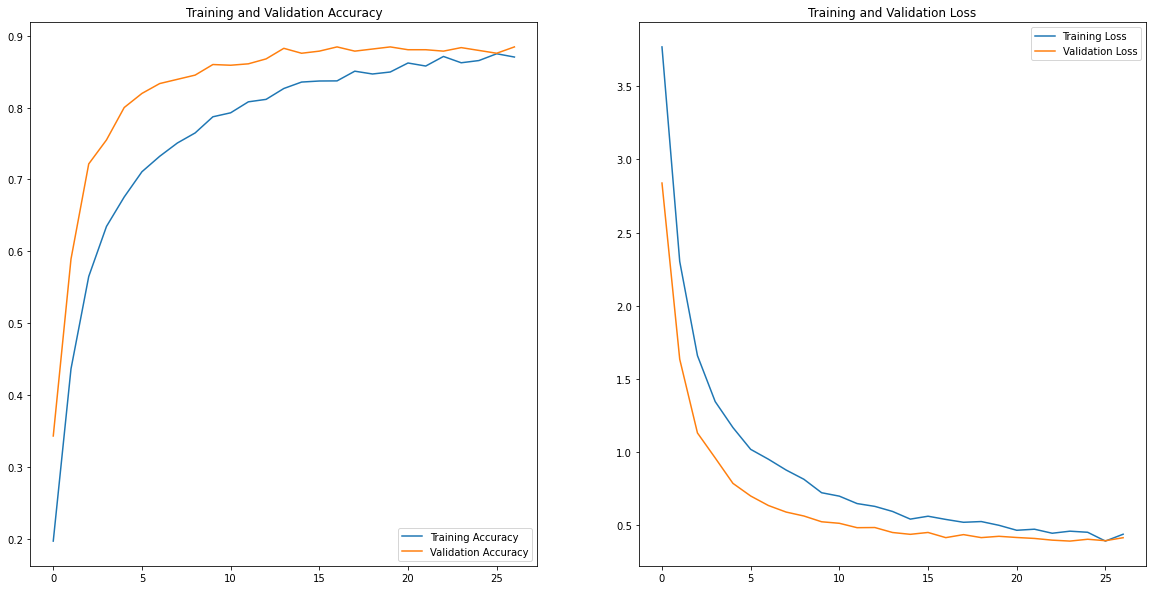

In [20]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing your Network

In [21]:
loss, accuracy = model.evaluate(test_batches)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

     16/Unknown - 3s 188ms/step - loss: 0.4925 - accuracy: 0.8637
Loss after training: 0.493
Accuracy after training: 86.373%
